## Classical Adaline (Adaptive Linear Neuron) for Binary MNIST Classification (NumPy)

This section implements the Adaline network. Adaline is similar to the Perceptron but uses a linear activation function (or identity function $f(x) = x$, which means practically the weighted sums) for weight updates and typically minimizes Mean Squared Error (MSE) using the Delta Rule (gradient descent).

Functions that are defined in previous notebooks, e.g. `compute_weighted_sum` and `step_function`, are imported here to keep it clean.


The Adaline paper by B. Widrow and H. Hoff can be found [here](https://isl.stanford.edu/~widrow/papers/t1960anadaptive.pdf).

In [1]:
# Adaline Helper Functions
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any

from src.utils.load_data import mnist
from src.utils.plot import plot_examples, plot_metrics
from src.preprocessing.data_transforms import normalize, shuffle_data
from src.components.activations import step_function
from src.components.blocks import compute_weighted_sum


%config InlineBackend.figure_format='retina'

train_images, train_labels, test_images, test_labels = mnist()

Dataset MNIST
    Number of datapoints     
    Train:  60000
    Test:   10000
    Source: https://ossci-datasets.s3.amazonaws.com/mnist/



## Binary Classification

In [14]:
binary_compare_labels = [4, 9]

idx2label = dict(enumerate(binary_compare_labels))
label2idx = {label: i for i, label in idx2label.items()}
binary_index = np.isin(train_labels, binary_compare_labels)
binary_train_labels = train_labels[binary_index]
binary_train_images = train_images[binary_index]
bninary_test_index = np.isin(test_labels, binary_compare_labels)
binary_test_labels = test_labels[bninary_test_index]
binary_test_images = test_images[bninary_test_index]

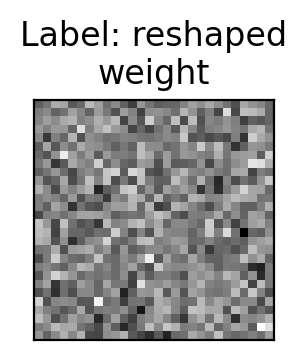

In [3]:
# initialize the weights and bias


def initialize_randn_weights(
    n_inputs: int,
    n_classes: int,
    bias_size: int = 1,
    mean: float = 0,
    std: float = 1,
    seed: int | None = None,
) -> np.ndarray:
    """
    Initialize weights with random values from a normal distribution (mean = 0, variance = 1).

    Args:
        n_inputs (int): Number of input features.
        n_outputs (int): Number of output neurons.
        bias_size (int): Size of the bias term. Default is 1.
        mean (float): mu or center of the normal distribution. Default is 0.
        std (float): Standard deviation of the normal distribution. Default is 1.
        seed (int | None): Random seed for reproducibility. Default is None.
    Returns:
        np.ndarray: Randomly initialized weights of shape (n_inputs + bias_size, n_outputs).
    """

    if n_classes <= 1:
        raise ValueError(
            "n_classes must be greater than 1 for a classification problem."
        )

    rng = np.random.default_rng(seed) if seed else np.random.default_rng()
    weights = (
        rng.normal(loc=mean, scale=std, size=(n_inputs + bias_size))
        if n_classes == 2
        else rng.normal(loc=mean, scale=std, size=(n_inputs + bias_size, n_classes))
    )

    return weights


plot_examples(
    [initialize_randn_weights(784, 2, 0, 0, 0.01).reshape(28, 28)],
    ["reshaped\nweight"],
    num_col=1,
    num_row=1,
)  # (28, 28, 1) is the shape of a single channel image

In [4]:
# inspect the weighted sum after applying the multiplication with the random weights.

compute_weighted_sum(
    normalize(train_images[0], -1, 1).flatten(),
    initialize_randn_weights(784, 2, 1, 0, 0.01),
)

np.float64(-0.1400089909743421)

In [5]:
def backward_pass(
    X: np.ndarray,
    y: np.ndarray | int,  # is it an array?
    weights: np.ndarray,
    learning_rate: float = 0.01,
    bias_size: int = 1,
) -> Tuple[np.ndarray, float]:
    # binary classification
    # print(weights.shape)
    if len(weights.shape) == 1:
        z = compute_weighted_sum(X, weights, bias_size)
        error_signal = z - label2idx.get(y)
        update = learning_rate * error_signal * np.hstack((X, np.ones(bias_size)))
        weights -= update

        # MSE
        loss = 0.5 * (error_signal**2)
        return weights, loss, z


weights, loss, z = backward_pass(
    normalize(binary_train_images[0], -1, 1).flatten(),
    binary_train_labels[0],
    initialize_randn_weights(784, 2, 1, 0, 0.01),
)
print(f"Updated weights: {weights.shape}\nloss: {loss}")

Updated weights: (785,)
loss: 0.040593559283122325


In [6]:
binary_train_images.shape[0]

11791

In [ ]:
# train function


def train_adaline(
    X_train: np.ndarray,
    y_train: np.ndarray,
    epochs: int = 10,
    learning_rate: float = 0.01,
    bias_size: int = 1,
) -> Tuple[np.ndarray, Dict[str, Any]]:
    # get the input shape and number of classes
    w_len = X_train[0].flatten().shape[0]
    n_classes = np.unique(y_train).shape[0]
    n_examples = X_train.shape[0]

    # initialize the weights
    weights = initialize_randn_weights(w_len, n_classes, bias_size, 0, 0.01)

    train_metrics = {"loss": np.zeros(epochs), "accuracy": np.zeros(epochs)}

    # iterate over the epochs
    for epoch in range(epochs):
        # shuffle the data
        X_train, y_train = shuffle_data(X_train, y_train)

        # epoch metrics
        epoch_loss = 0
        correct_preds = 0

        # iterate over the training data
        for image, label in zip(X_train, y_train):
            # flatten the image
            transformed_image = normalize(image, 0, 1).flatten()

            # co,pute the backward pass and update the weights (here 'leaarns' the network)
            weights, loss, z = backward_pass(
                transformed_image, label, weights, learning_rate, bias_size
            )

            # add the loss
            epoch_loss += loss

            # compute the accuracy
            pred = idx2label.get(
                step_function(z, threshold=0.5).item()
            )  # i set the threshold between min and max
            if pred == label:
                correct_preds += 1

        # compute the epoch metrics
        epoch_loss /= n_examples
        epoch_accuracy = correct_preds / n_examples

        # save the metrics
        train_metrics["loss"][epoch] = epoch_loss
        train_metrics["accuracy"][epoch] = epoch_accuracy

        print(
            f"Epoch {epoch}: Loss: {epoch_loss:.4f}, Accuracy: {train_metrics['accuracy'][epoch]:.4f}"
        )
    return weights, train_metrics

In [12]:
weights, train_metrics = train_adaline(
    binary_train_images, binary_train_labels, epochs=10, learning_rate=0.0005
)

Epoch 0: Loss: 0.0381, Accuracy: 0.9269
Epoch 1: Loss: 0.0292, Accuracy: 0.9504
Epoch 2: Loss: 0.0276, Accuracy: 0.9550
Epoch 3: Loss: 0.0268, Accuracy: 0.9566
Epoch 4: Loss: 0.0262, Accuracy: 0.9578
Epoch 5: Loss: 0.0259, Accuracy: 0.9594
Epoch 6: Loss: 0.0256, Accuracy: 0.9618
Epoch 7: Loss: 0.0253, Accuracy: 0.9619
Epoch 8: Loss: 0.0251, Accuracy: 0.9610
Epoch 9: Loss: 0.0250, Accuracy: 0.9621


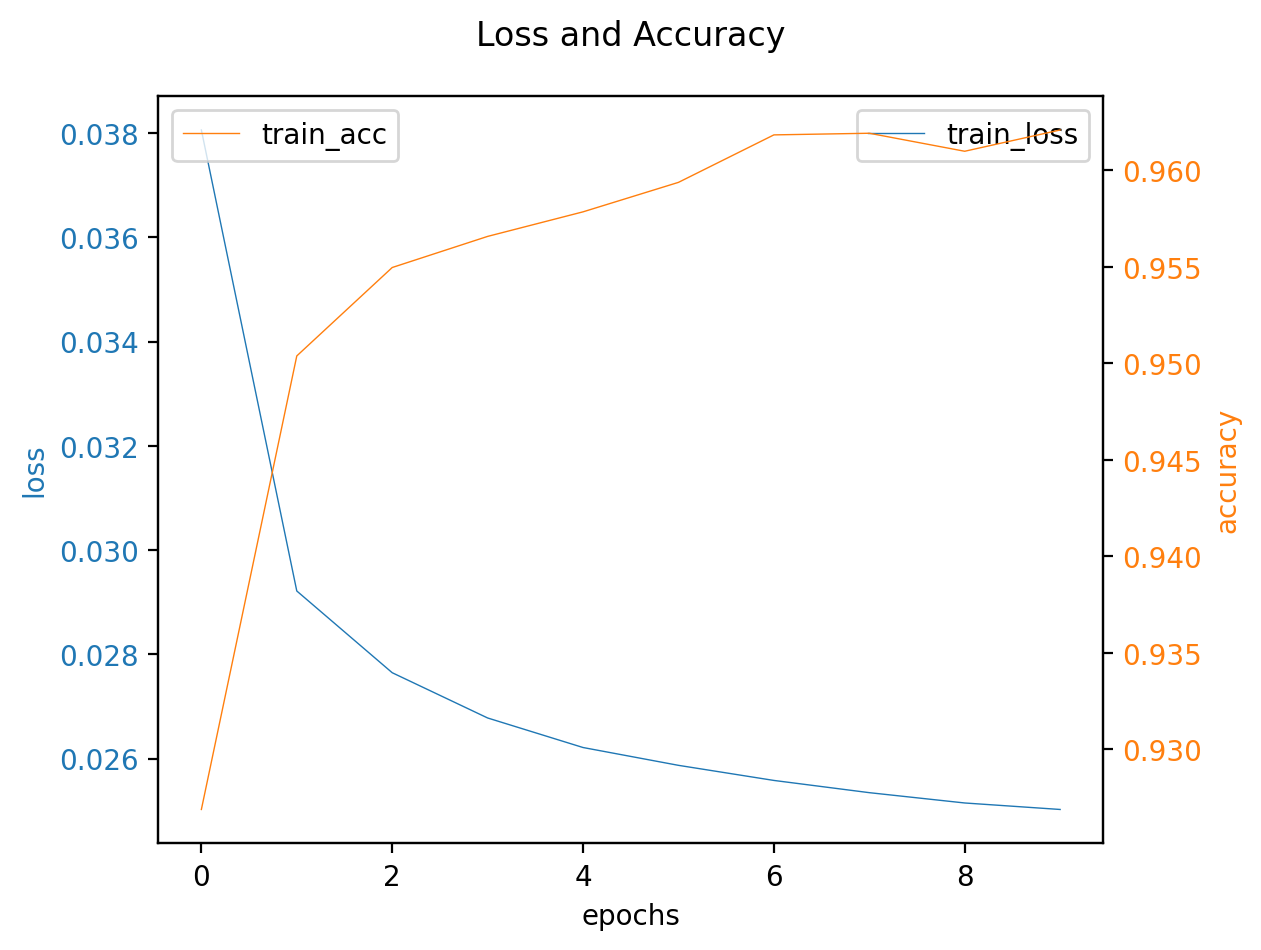

In [13]:
plot_metrics(train_metrics)

In [21]:
def predict(X: np.ndarray, weights: np.ndarray, bias_size: int = 1) -> np.ndarray:
    """
    Predict the labels for the input data using the trained weights.

    Args:
        X (np.ndarray): Input data of shape (n_samples, n_features).
        weights (np.ndarray): Trained weights of shape (n_features + bias_size, n_classes).
        bias_size (int): Size of the bias term. Default is 1.

    Returns:
        np.ndarray: Predicted labels of shape (n_samples,).
    """
    predictions = np.zeros(X.shape[0])
    for i, image in enumerate(X):  # iterate over the X:
        transformed_image = normalize(image, 0, 1).round(decimals=0).flatten()
        z = compute_weighted_sum(transformed_image, weights, bias_size)
        pred = idx2label.get(step_function(z, threshold=0.5).item())
        predictions[i] = pred
    return np.array(predictions)

In [22]:
def eval_adaline(
    X_test: np.ndarray,
    y_test: np.ndarray,
    weights: np.ndarray,
    # random_weight: np.ndarray,
    bias_size: int = 1,
) -> tuple:
    """eval evaluates the perceptron using the test data.

    Args:
        X_test (np.ndarray): test data
        y_test (np.ndarray): test labels
        weights (np.ndarray): weights
        bias_size (int, optional): size of the bias. Defaults to 1.

    Returns:
        tuple: accuracy and predictions
    """

    predictions = predict(X_test, weights, bias_size)

    # calculate accuracy
    accuracy = np.sum(predictions == y_test) / len(y_test)

    return accuracy, predictions


# evaluate the perceptron
accuracy, predictions = eval_adaline(
    binary_test_images, binary_test_labels, weights, bias_size=1
)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.955


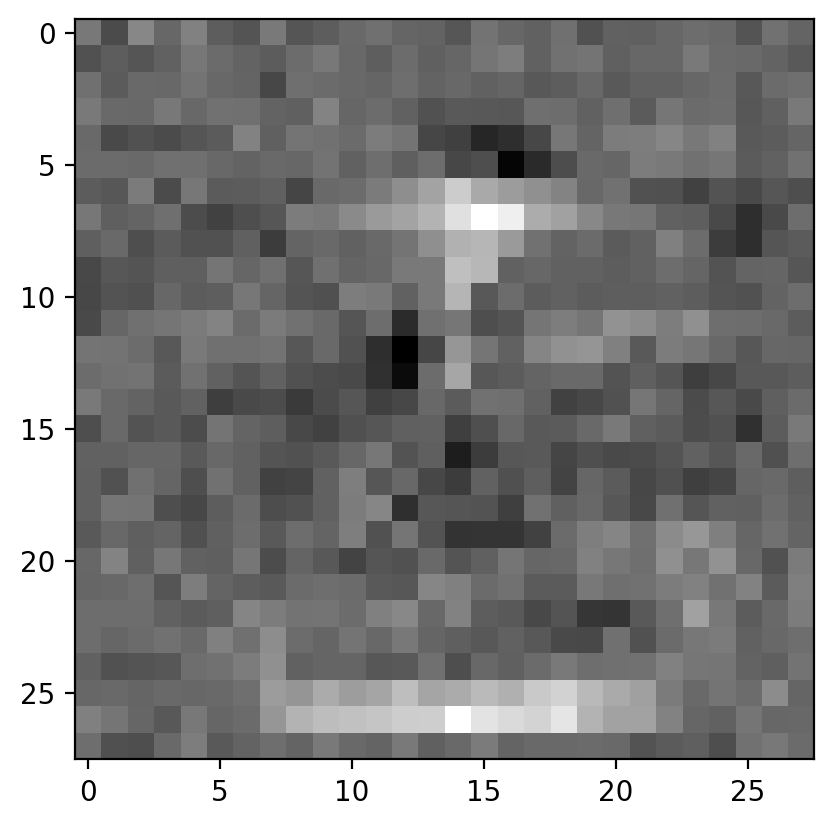

In [23]:
plt.imshow(weights[:-1].reshape(28, 28), cmap="gray")
plt.show()

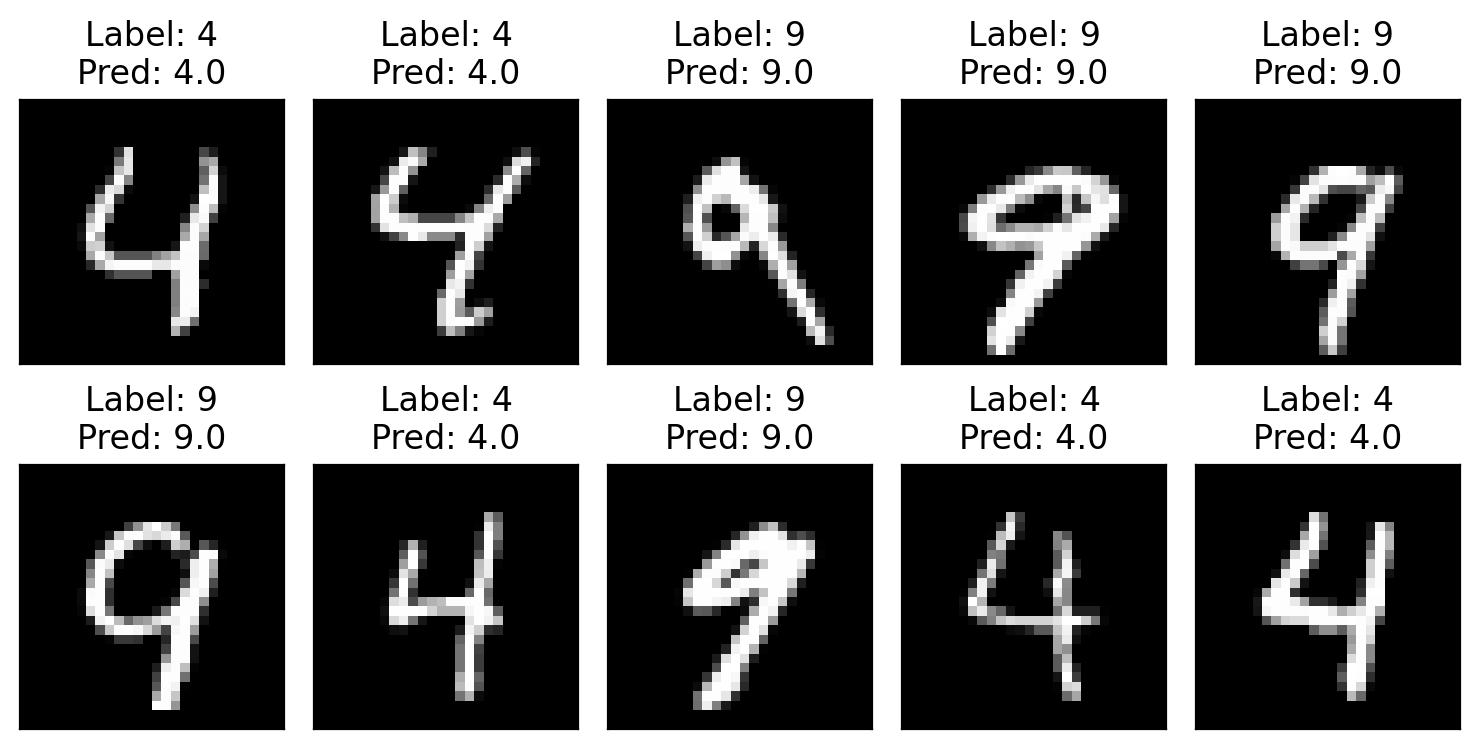

In [ ]:
plot_examples(
    binary_test_images[:10],
    labels=binary_test_labels[:10],
    predictions=predict(binary_test_images[:10], weights, bias_size=1),
)

## Multiclass Adaline in Construction 🔨